In [42]:
import pandas as pd
import numpy as np 
import sqlite3
import nltk
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import scipy as sp
import sqlite3
import re
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [74]:
conn = sqlite3.connect("/Users/jackmackle/py_work/jacksbot/storage/storage.db")
df = pd.read_sql_query("SELECT * FROM tweets", conn)
conn.close()

# VADER - No Cleaning

In [64]:
sid = SentimentIntensityAnalyzer()

In [33]:
tw_text_list = df["full_text"].tolist()
polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

In [34]:
df["compound_pol"] = compound

<AxesSubplot:xlabel='compound_pol', ylabel='Count'>

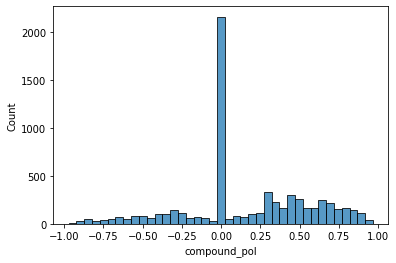

In [35]:
sns.histplot(data=df, x="compound_pol")

# VADER - Cleaning

In [75]:
df_clean = df

In [76]:
tw_text_list = df_clean["full_text"].tolist()

def remove_handles(text):
    r = re.findall("@[\w]*", text)
    for i in r:
        text = re.sub(i, "", text)
        
    return text

tw_text_list = list(map(remove_handles, tw_text_list))

def remove_links(text):
    r = re.findall("https?://[A-Za-z0-9./]*", text)
    for i in r:
        text = re.sub(i, "", text)
        
    return text

tw_text_list = list(map(remove_links, tw_text_list))

In [77]:
polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

In [78]:
df_clean["compound_pol"] = compound

<AxesSubplot:xlabel='compound_pol', ylabel='Count'>

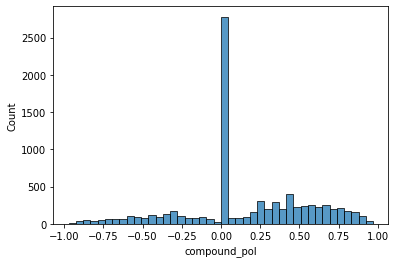

In [79]:
sns.histplot(data=df_clean, x="compound_pol")

In [80]:
for i in df_clean['stripdate'].unique():
    fig = sm.qqplot(df_clean[df_clean['stripdate'] == i]['compound_pol'])
    plt.title(i)
    plt.show()

KeyError: 'stripdate'

In [81]:
df_clean.columns

Index(['tweet_id', 'created_at', 'in_reply_to_status', 'full_text', 'verified',
       'retweet_count', 'user_id', 'user_name', 'user_followers_coubt',
       'compound_pol'],
      dtype='object')

In [82]:
df_cbs = df_clean.groupby("user_name", as_index=False)["compound_pol"].mean()
df_cbs.sort_values(by="compound_pol", ascending=False)

,user_name,compound_pol
255,DMSeII4Mayor,0.9565
1036,WallStreetU3O8,0.9434
812,SamTheCarpetMan,0.9401
610,MiningFan,0.9297
770,ReinhardAustrup,0.9246
...,...,...
328,EriCheri3,-0.9112
1541,saaedsabzian,-0.9136
1223,drizham,-0.9186
817,Sarah4Durham,-0.9222


In [83]:
#pd.to_datetime(pd.Series(['2022-02-27 19:15:57+00:00']), format="%m/%d/%Y")

strip_date = list(map(lambda x: x.split()[0], df_clean["created_at"].to_list()))
df_clean["stripdate"] = strip_date

In [84]:
df_clean[["stripdate", "compound_pol"]].groupby("stripdate", as_index=False).agg(['count','mean']).reset_index()

stripdate compound_pol          
                      count      mean
0   2022-02-22           61  0.176889
1   2022-02-23          336  0.204645
2   2022-02-24          490  0.147176
3   2022-02-25          520  0.202389
4   2022-02-26          279  0.225790
5   2022-02-27          287  0.142606
6   2022-02-28          573  0.147505
7   2022-03-01          600  0.211371
8   2022-03-02          637  0.159918
9   2022-03-03          530  0.197516
10  2022-03-04          814  0.027661
11  2022-03-05          317  0.183103
12  2022-03-06          266  0.157923
13  2022-03-07          636  0.168501
14  2022-03-08          761  0.104196
15  2022-03-09          116  0.188537
16  2022-03-10          957  0.164424
17  2022-03-11          120  0.125021

<AxesSubplot:xlabel='stripdate', ylabel='compound_pol'>

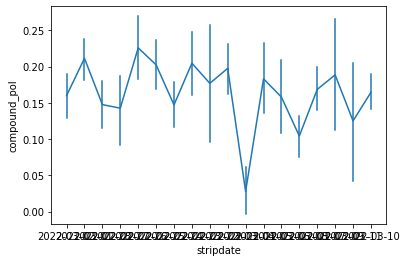

In [85]:
sns.lineplot(data=df_clean,
            x="stripdate",
            y="compound_pol",
            err_style="bars")